In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from datetime import datetime 
pd.options.mode.chained_assignment = 'warn'  # default='warn'

In [2]:
scaler = StandardScaler(with_std=True, with_mean=True)

def filter_pca_data(df: pd.DataFrame, dropped_depths: list[int] = []):
    dropped_features = [
        'Unnamed: 0',
        'TIMESTAMP',
        'RECORD',
        'TIMESTAMP_DIFF',
        'Redox_error_flag_available',
        'log_redox(1)',
        'log_redox(2)',
        'log_redox(3)',
        'log_redox(4)',
        'log_redox(5)',
        'neg_log(1)',
        'neg_log(2)',
        'neg_log(3)',
        'neg_log(4)',
        'neg_log(5)',
        'Temp_T21_Avg(1)',
        'Temp_T21_Avg(2)',
        'Temp_T21_Avg(3)',
        'Temp_T21_Avg(4)',
        'Temp_T21_Avg(5)',
        'Redox_error_flag',
        'Redox_error_flag(1)',
        'Redox_error_flag(2)',
        'Redox_error_flag(3)',
        'Redox_error_flag(4)',
        'Redox_error_flag(5)',
        'CCVWC_Avg(1)',
        'CCVWC_Avg(2)',
        'CCVWC_Avg(3)',
        'CCVWC_Avg(4)',
        'CCVWC_Avg(5)',
        'shf_plate_Avg',
        'shf_multiplier',
        'shf_htr_resstnc',
        'shfp_wrnng_flg',
        'btt_wrnng_flg',
        'BatterymV_Min',
        'pit_number',
        # 'Redox_Avg(1)_sigma_b_12',
        # 'Redox_Avg(1)_sigma_f_12',
        # 'Redox_Avg(2)_sigma_b_12',
        # 'Redox_Avg(2)_sigma_f_12',
        # 'Redox_Avg(3)_sigma_b_12',
        # 'Redox_Avg(3)_sigma_f_12',
        # 'Redox_Avg(4)_sigma_b_12',
        # 'Redox_Avg(4)_sigma_f_12',
        # 'Redox_Avg(5)_sigma_b_12',
        # 'Redox_Avg(5)_sigma_f_12',
        # 'Redox_Avg(1)_sigma_b_24',
        # 'Redox_Avg(1)_sigma_f_24',
        # 'Redox_Avg(2)_sigma_b_24',
        # 'Redox_Avg(2)_sigma_f_24',
        # 'Redox_Avg(3)_sigma_b_24',
        # 'Redox_Avg(3)_sigma_f_24',
        # 'Redox_Avg(4)_sigma_b_24',
        # 'Redox_Avg(4)_sigma_f_24',
        # 'Redox_Avg(5)_sigma_b_24',
        # 'Redox_Avg(5)_sigma_f_24',
    ]
    for d in dropped_depths:
        dropped_features.extend([
            f'Redox_Avg({d})',
            f'EC_Avg({d})',
            f'Temp_T12_Avg({d})',
            f'Matric_potential_Avg({d})',
            f'WC{d}',
            f'Redox_Avg({d})_sigma_f'
            f'Redox_Avg({d})_sigma_b'
        ])
    pca_data = df.loc[:, ~df.columns.isin(dropped_features)]
    return pca_data
    

def getDistanceByPoint(data: pd.DataFrame, model: KMeans):
    cluster_centers_per_label = pd.DataFrame(model.cluster_centers_).loc[model.labels_].reset_index().drop('index', axis=1)
    return pd.DataFrame(np.linalg.norm(cluster_centers_per_label - data, axis=1))

def get_pca_scores(pca_data, n_components):
    scaled = scaler.fit_transform(pca_data)
    pca = PCA(n_components)
    return pca.fit_transform(scaled)

def k_means(data, n_clusters):
    model = KMeans(n_clusters, n_init=10).fit(data)
    return model.predict(data), model

def pca_kmeans(pca_data, full_data, n_clusters, n_components, outliers_fraction):
    pca_scores = get_pca_scores(pca_data, n_components)
    scaled_pca_scores = scaler.fit_transform(pca_scores)
    data = pd.DataFrame(scaled_pca_scores)

    clusters, model = k_means(data, n_clusters)
    distance = getDistanceByPoint(data, model)
    outlier_num = int(outliers_fraction * len(distance))
    threshold = distance.nlargest(outlier_num, columns=[0]).min()
    is_anomaly = (distance >= threshold)
    full_data = full_data.assign(cluster=clusters, anomaly=is_anomaly.to_numpy(), d_from_cc= distance.to_numpy())
    return full_data

def get_acc_metric_dfs(df: pd.DataFrame):
    # true_positives = df.query('(`Redox_error_flag(1)` == True | `Redox_error_flag(2)` == True | `Redox_error_flag(3)` == True | `Redox_error_flag(4)` == True | `Redox_error_flag(5)` == True) & (anomaly == True)')
    # false_positives = df.query('(`Redox_error_flag(1)` == False & `Redox_error_flag(2)` == False & `Redox_error_flag(3)` == False & `Redox_error_flag(4)` == False & `Redox_error_flag(5)` == False) & (anomaly == True)')
    true_positives = df[((df['Redox_error_flag(1)'] == True) | (df['Redox_error_flag(2)'] == True) | (df['Redox_error_flag(3)'] == True) | (df['Redox_error_flag(4)'] == True) | (df['Redox_error_flag(5)'] == True)) & (df['anomaly'] == True)]
    false_positives = df[((df['Redox_error_flag(1)'] == False) & (df['Redox_error_flag(2)'] == False) & (df['Redox_error_flag(3)'] == False) & (df['Redox_error_flag(4)'] == False) & (df['Redox_error_flag(5)'] == False)) & (df['anomaly'] == True)]
    true_negatives = df[((df['Redox_error_flag(1)'] == False) & (df['Redox_error_flag(2)'] == False) & (df['Redox_error_flag(3)'] == False) & (df['Redox_error_flag(4)'] == False) & (df['Redox_error_flag(5)'] == False)) & (df['anomaly'] == False)]
    false_negatives = df[((df['Redox_error_flag(1)'] == True) | (df['Redox_error_flag(2)'] == True) | (df['Redox_error_flag(3)'] == True) | (df['Redox_error_flag(4)'] == True) | (df['Redox_error_flag(5)'] == True)) & (df['anomaly'] == False)]
    return (true_positives, true_negatives, false_positives, false_negatives)

def get_ind_depth_acc_metric_dfs(df: pd.DataFrame, pit: int):
    # true_positives = df.query('(`Redox_error_flag(1)` == True | `Redox_error_flag(2)` == True | `Redox_error_flag(3)` == True | `Redox_error_flag(4)` == True | `Redox_error_flag(5)` == True) & (anomaly == True)')
    # false_positives = df.query('(`Redox_error_flag(1)` == False & `Redox_error_flag(2)` == False & `Redox_error_flag(3)` == False & `Redox_error_flag(4)` == False & `Redox_error_flag(5)` == False) & (anomaly == True)')
    true_positives = df[(df[f'Redox_error_flag({pit})'] == True) & (df['anomaly'] == True)]
    false_positives = df[(df[f'Redox_error_flag({pit})'] == False) & (df['anomaly'] == True)]
    true_negatives = df[(df[f'Redox_error_flag({pit})'] == False) & (df['anomaly'] == False)]
    false_negatives = df[(df[f'Redox_error_flag({pit})'] == True) & (df['anomaly'] == False)]
    return (true_positives, true_negatives, false_positives, false_negatives)

def get_acc_metrics(acc_metric_dfs: tuple[pd.DataFrame]):
    true_positives, true_negatives, false_positives, false_negatives = acc_metric_dfs
    acc = (true_positives.shape[0] + true_negatives.shape[0]) / (true_positives.shape[0] + true_negatives.shape[0] + false_positives.shape[0] + false_negatives.shape[0])
    prec = true_positives.shape[0] / (true_positives.shape[0] + false_positives.shape[0])
    rec = true_positives.shape[0] / (true_positives.shape[0] + false_negatives.shape[0])
    return (acc, prec, rec)

# def compare_shifted(anomalys):
#     shifted = (anomalys.shift(-1) | anomalys.shift(1))
#     return (anomalys | shifted)

In [3]:
all_training_data = pd.read_csv('../../Data/Training/Raw_training_data_full.csv', parse_dates=['TIMESTAMP'])
training_data_2022 = all_training_data.loc[all_training_data['TIMESTAMP'] < datetime(2023, 1,1, 0, 0, 0), :]
training_data_2023 = all_training_data.loc[all_training_data['TIMESTAMP'] >= datetime(2023, 1,1, 0, 0, 0), :]

/tmp/ipykernel_15651/575840907.py:1: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  all_training_data = pd.read_csv('../../Data/Training/Raw_training_data_full.csv', parse_dates=['TIMESTAMP'])


In [4]:
pca_data = filter_pca_data(all_training_data)
scaler = StandardScaler(with_std=True, with_mean=True)
scaled = scaler.fit_transform(pca_data)
pca = PCA()
pca.fit(scaled)
scores = pca.transform(scaled)

In [5]:
print(pd.DataFrame({'feature': pca_data.columns, 'loadings': pca.components_[0]}).set_index('feature').sort_values(by='loadings', ascending=False))

                         loadings
feature                          
Redox_Avg(4)_sigma_f_24  0.234052
Redox_Avg(4)_sigma_b_24  0.233355
Redox_Avg(5)_sigma_f_24  0.232147
Redox_Avg(5)_sigma_b_24  0.231934
Redox_Avg(3)_sigma_f_24  0.231802
Redox_Avg(3)_sigma_b_24  0.230870
Redox_Avg(4)_sigma_f_12  0.228501
Redox_Avg(3)_sigma_f_12  0.228131
Redox_Avg(4)_sigma_b_12  0.228043
Redox_Avg(3)_sigma_b_12  0.227455
Redox_Avg(5)_sigma_f_12  0.226790
Redox_Avg(5)_sigma_b_12  0.226580
Redox_Avg(2)_sigma_f_24  0.223163
Redox_Avg(2)_sigma_f_12  0.222687
Redox_Avg(2)_sigma_b_24  0.222386
Redox_Avg(2)_sigma_b_12  0.222009
Redox_Avg(1)_sigma_b_12  0.141682
Redox_Avg(1)_sigma_f_12  0.139154
Redox_Avg(1)_sigma_b_24  0.134139
Redox_Avg(1)_sigma_f_24  0.129484
Redox_Avg(2)             0.109041
Redox_Avg(3)             0.096695
Redox_Avg(4)             0.082296
Redox_Avg(1)             0.067542
Temp_T12_Avg(3)          0.065599
Temp_T12_Avg(2)          0.063842
Temp_T12_Avg(4)          0.062345
Temp_T12_Avg(5

In [6]:
print(pd.DataFrame({'feature': pca_data.columns, 'loadings': pca.components_[1]}).set_index('feature').sort_values(by='loadings', ascending=False))

                         loadings
feature                          
Temp_T12_Avg(4)          0.278969
Temp_T12_Avg(5)          0.277626
Temp_T12_Avg(3)          0.265647
Temp_T12_Avg(2)          0.256206
Temp_T12_Avg(1)          0.231231
Temp_ottpls_Avg          0.213305
Redox_Avg(3)             0.063057
Redox_Avg(4)             0.061041
Redox_Avg(5)             0.049453
EC_Avg(5)                0.034107
Redox_Avg(2)             0.024242
EC_Avg(1)                0.016912
Redox_Avg(1)            -0.023765
Redox_Avg(1)_sigma_f_12 -0.050176
Redox_Avg(5)_sigma_b_24 -0.050725
Redox_Avg(5)_sigma_f_24 -0.050852
Redox_Avg(5)_sigma_b_12 -0.052234
Redox_Avg(1)_sigma_b_12 -0.052348
Redox_Avg(4)_sigma_b_24 -0.052373
Redox_Avg(4)_sigma_f_24 -0.052580
Redox_Avg(5)_sigma_f_12 -0.052604
Redox_Avg(2)_sigma_b_24 -0.053372
Redox_Avg(2)_sigma_f_24 -0.053375
Redox_Avg(1)_sigma_f_24 -0.053632
Redox_Avg(4)_sigma_b_12 -0.053680
Redox_Avg(4)_sigma_f_12 -0.054100
Redox_Avg(2)_sigma_b_12 -0.054386
Redox_Avg(3)_s

In [7]:
print(pd.DataFrame({'feature': pca_data.columns, 'loadings': pca.components_[2]}).set_index('feature').sort_values(by='loadings', ascending=False))

                         loadings
feature                          
EC_Avg(5)                0.325097
EC_Avg(4)                0.320978
EC_Avg(2)                0.294358
EC_Avg(3)                0.201710
EC_Avg(1)                0.157722
Temp_T12_Avg(1)          0.146707
Temp_T12_Avg(2)          0.144846
Temp_T12_Avg(3)          0.138801
Temp_T12_Avg(4)          0.128228
Temp_T12_Avg(5)          0.109502
WC1                      0.106995
Matric_potential_Avg(4)  0.076275
Matric_potential_Avg(3)  0.064476
Temp_ottpls_Avg          0.045353
WC2                      0.039731
Matric_potential_Avg(2)  0.039432
Water_level_Avg          0.034045
Redox_Avg(3)_sigma_f_24  0.030783
Redox_Avg(4)_sigma_f_24  0.029020
Redox_Avg(2)_sigma_f_24  0.028632
Redox_Avg(5)_sigma_f_24  0.028563
Redox_Avg(3)_sigma_f_12  0.027252
Redox_Avg(3)_sigma_b_24  0.026849
Redox_Avg(2)_sigma_f_12  0.026531
Redox_Avg(2)_sigma_b_24  0.025494
Redox_Avg(4)_sigma_f_12  0.025332
Matric_potential_Avg(5)  0.025001
Redox_Avg(4)_s

In [8]:
print(pd.DataFrame({'feature': pca_data.columns, 'loadings': pca.components_[3]}).set_index('feature').sort_values(by='loadings', ascending=False))

                         loadings
feature                          
EC_Avg(5)                0.180793
EC_Avg(2)                0.083690
EC_Avg(4)                0.067288
Redox_Avg(4)_sigma_f_24  0.010485
Redox_Avg(3)_sigma_f_24  0.009710
Redox_Avg(3)_sigma_f_12  0.008219
Redox_Avg(4)_sigma_f_12  0.008115
Redox_Avg(4)_sigma_b_24  0.007952
Redox_Avg(3)_sigma_b_24  0.007882
Redox_Avg(5)_sigma_f_24  0.007090
Redox_Avg(5)_sigma_f_12  0.005582
Redox_Avg(2)_sigma_f_12  0.005184
Redox_Avg(3)_sigma_b_12  0.005060
Redox_Avg(4)_sigma_b_12  0.004686
Redox_Avg(5)_sigma_b_24  0.004100
Redox_Avg(2)_sigma_f_24  0.003809
Redox_Avg(2)_sigma_b_24  0.002555
Redox_Avg(2)_sigma_b_12  0.002271
Redox_Avg(5)_sigma_b_12  0.001805
EC_Avg(3)               -0.003532
Redox_Avg(3)            -0.018380
Redox_Avg(1)_sigma_b_12 -0.028874
Redox_Avg(2)            -0.031824
Redox_Avg(1)_sigma_f_12 -0.032341
Redox_Avg(1)_sigma_b_24 -0.034147
Redox_Avg(5)            -0.040255
Redox_Avg(1)_sigma_f_24 -0.041229
Redox_Avg(1)  

In [9]:
print(pd.DataFrame({'feature': pca_data.columns, 'loadings': pca.components_[4]}).set_index('feature').sort_values(by='loadings', ascending=False))

                         loadings
feature                          
EC_Avg(1)                0.426288
WC1                      0.357628
Temp_ottpls_Avg          0.220205
Redox_Avg(1)_sigma_f_24  0.206328
Redox_Avg(1)_sigma_b_24  0.188693
Redox_Avg(5)             0.180688
Redox_Avg(1)_sigma_f_12  0.180034
Matric_potential_Avg(1)  0.175317
Redox_Avg(1)_sigma_b_12  0.167084
EC_Avg(2)                0.139497
Matric_potential_Avg(2)  0.115917
WC2                      0.080867
EC_Avg(3)                0.044803
Redox_Avg(2)_sigma_f_24  0.041290
Redox_Avg(2)_sigma_f_12  0.035759
Temp_T12_Avg(5)          0.032911
Redox_Avg(2)_sigma_b_24  0.032574
Redox_Avg(2)_sigma_b_12  0.027677
WC3                      0.018439
Matric_potential_Avg(3)  0.009505
Redox_Avg(3)_sigma_f_12 -0.001597
Redox_Avg(3)_sigma_f_24 -0.002219
Redox_Avg(2)            -0.003623
Redox_Avg(3)_sigma_b_12 -0.008923
Redox_Avg(3)_sigma_b_24 -0.010226
Redox_Avg(4)            -0.012914
Redox_Avg(3)            -0.017838
Redox_Avg(4)_s

In [10]:
print(pd.DataFrame({'feature': pca_data.columns, 'loadings': pca.components_[5]}).set_index('feature').sort_values(by='loadings', ascending=False))

                         loadings
feature                          
Redox_Avg(1)_sigma_f_24  0.351527
Redox_Avg(1)_sigma_f_12  0.351093
WC4                      0.218208
WC5                      0.189551
Redox_Avg(2)_sigma_f_12  0.149868
Redox_Avg(2)_sigma_f_24  0.144984
Redox_Avg(3)_sigma_f_12  0.110356
Redox_Avg(3)_sigma_f_24  0.101111
Redox_Avg(4)_sigma_f_12  0.088608
Redox_Avg(4)_sigma_f_24  0.074762
Redox_Avg(5)_sigma_f_12  0.070830
Redox_Avg(1)_sigma_b_24  0.063116
Redox_Avg(1)_sigma_b_12  0.059268
Redox_Avg(5)_sigma_f_24  0.054552
Water_level_Avg          0.051936
Temp_T12_Avg(1)          0.042496
Temp_T12_Avg(2)          0.039810
Temp_T12_Avg(3)          0.024946
WC3                      0.016131
Matric_potential_Avg(4)  0.008631
Redox_Avg(5)             0.008335
Temp_T12_Avg(4)          0.000470
Matric_potential_Avg(5) -0.004026
Temp_T12_Avg(5)         -0.034562
EC_Avg(4)               -0.038885
EC_Avg(1)               -0.052885
EC_Avg(2)               -0.065171
WC2           

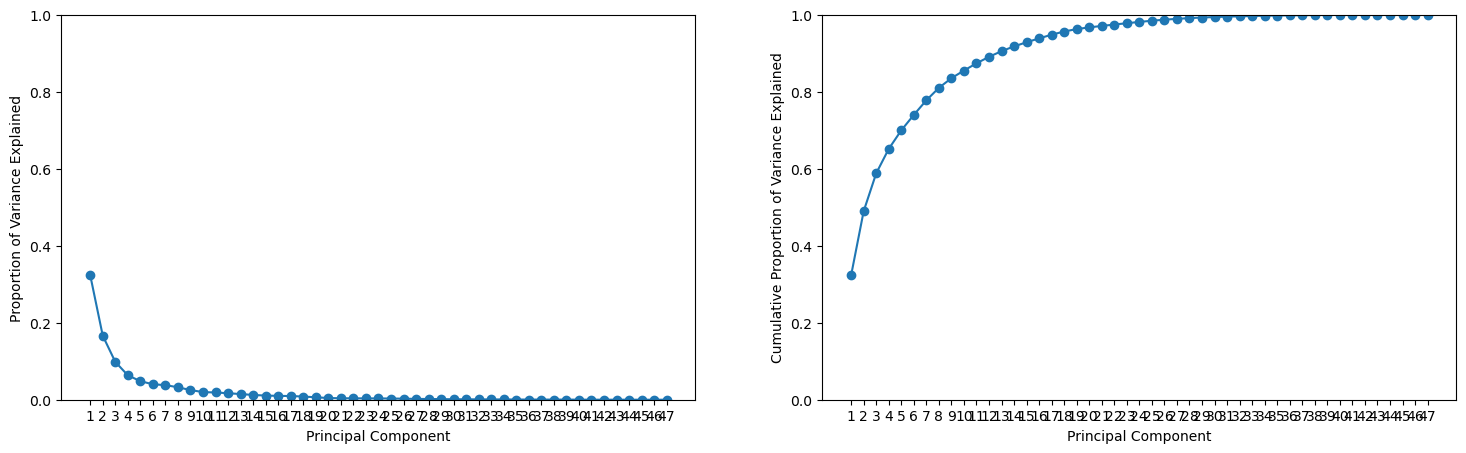

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.set_size_inches((18,5))
ticks = np.arange(pca.n_components_)+1
ax = axes[0]
ax.plot(ticks, pca.explained_variance_ratio_, marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Proportion of Variance Explained')
ax.set_ylim([0,1])
ax.set_xticks(ticks)
ax = axes[1]
ax.plot(ticks, pca.explained_variance_ratio_.cumsum(), marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative Proportion of Variance Explained')
ax.set_ylim([0, 1])
ax.set_xticks(ticks)

## 2022 whole data

In [12]:
outliers_fraction = 0.37
pca_data = filter_pca_data(training_data_2022)

for components in range(5,7):
    for clusters in range(5,7):
        anomaly_data = pca_kmeans(pca_data, training_data_2022, clusters, components, outliers_fraction)
        acc, prec, rec = get_acc_metrics(get_acc_metric_dfs(anomaly_data))
        print(f'Components: {components}, clusters: {clusters}, acc: {acc}, precision: {prec}, recall: {rec}')


Components: 5, clusters: 5, acc: 0.7661246433276198, precision: 0.6927486425183862, recall: 0.6807700101317122
Components: 5, clusters: 6, acc: 0.6646643846415983, precision: 0.5556395628565537, recall: 0.546031746031746
Components: 6, clusters: 5, acc: 0.7894602993759187, precision: 0.7242834559076226, recall: 0.7117595406957109
Components: 6, clusters: 6, acc: 0.689393669669242, precision: 0.5890576671936215, recall: 0.57887200270179


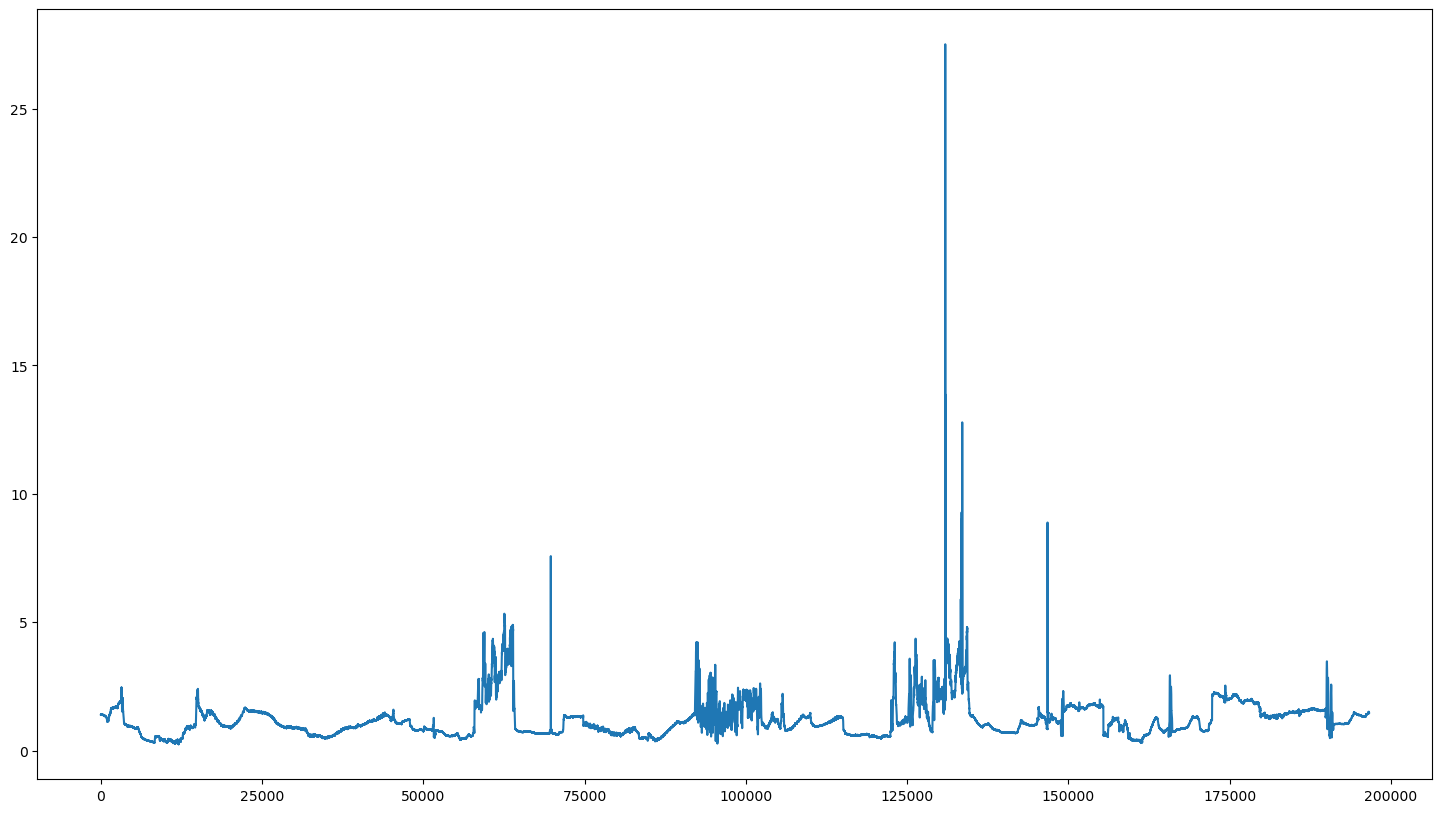

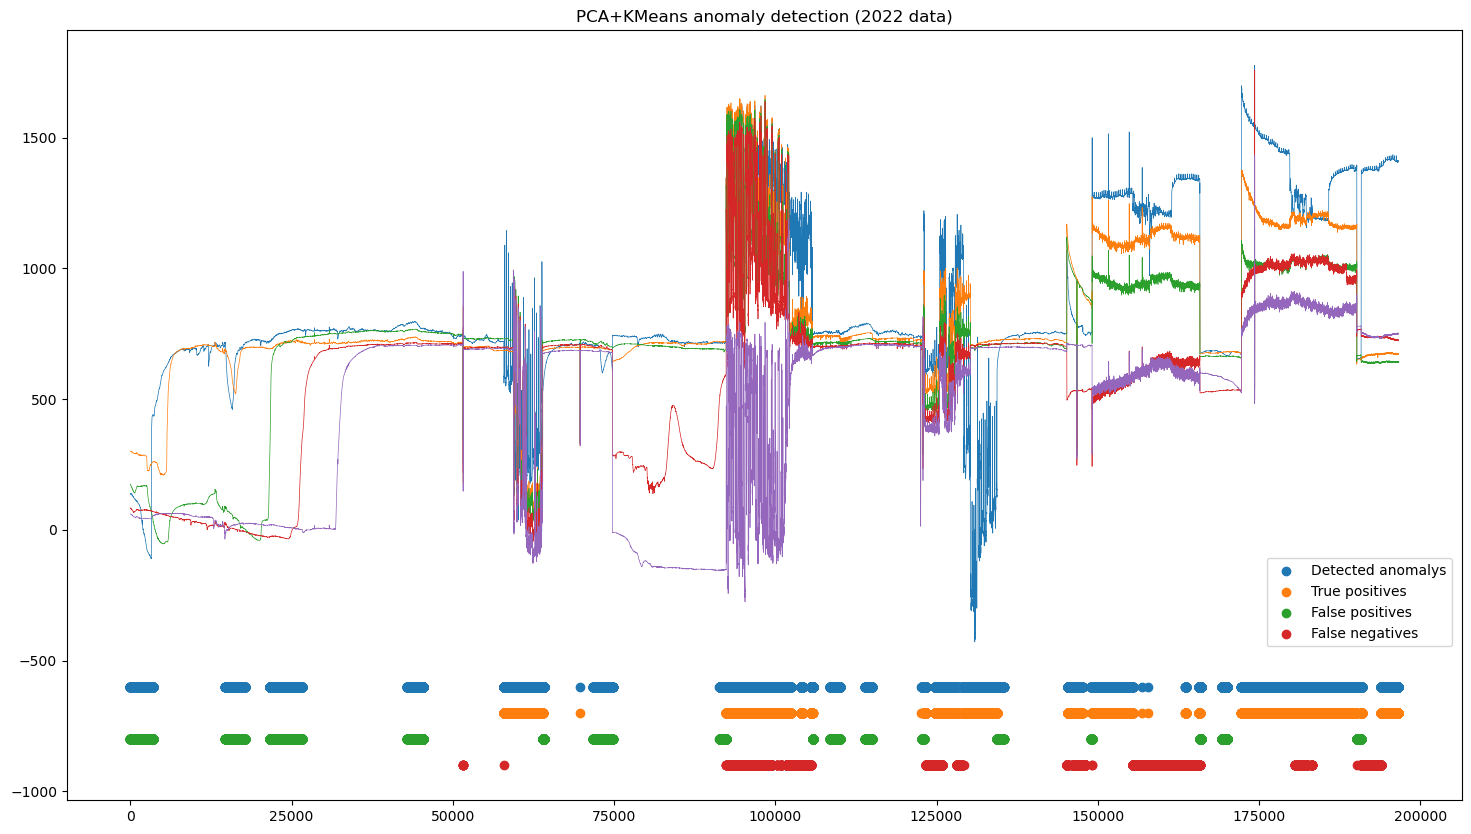

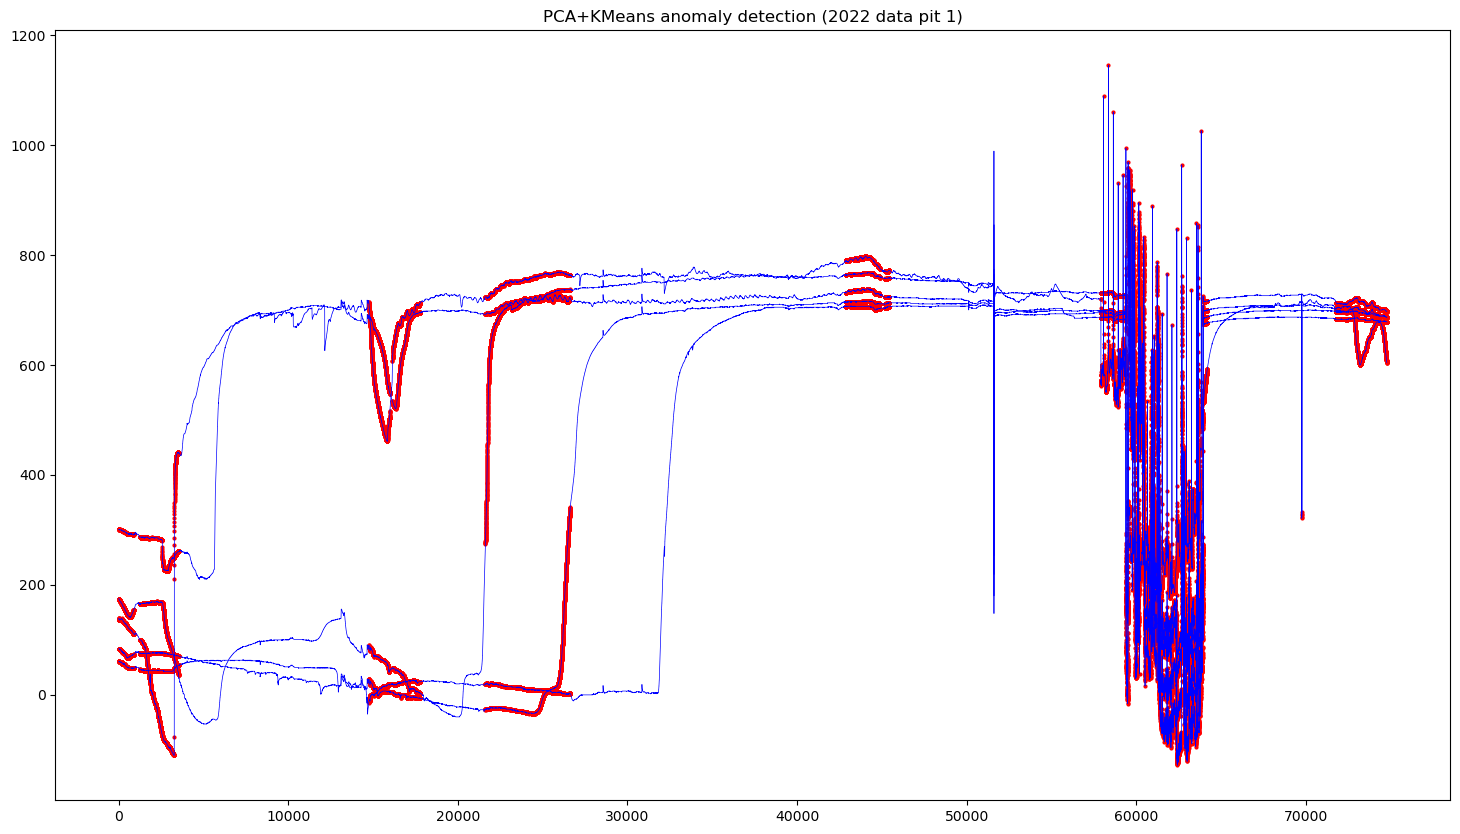

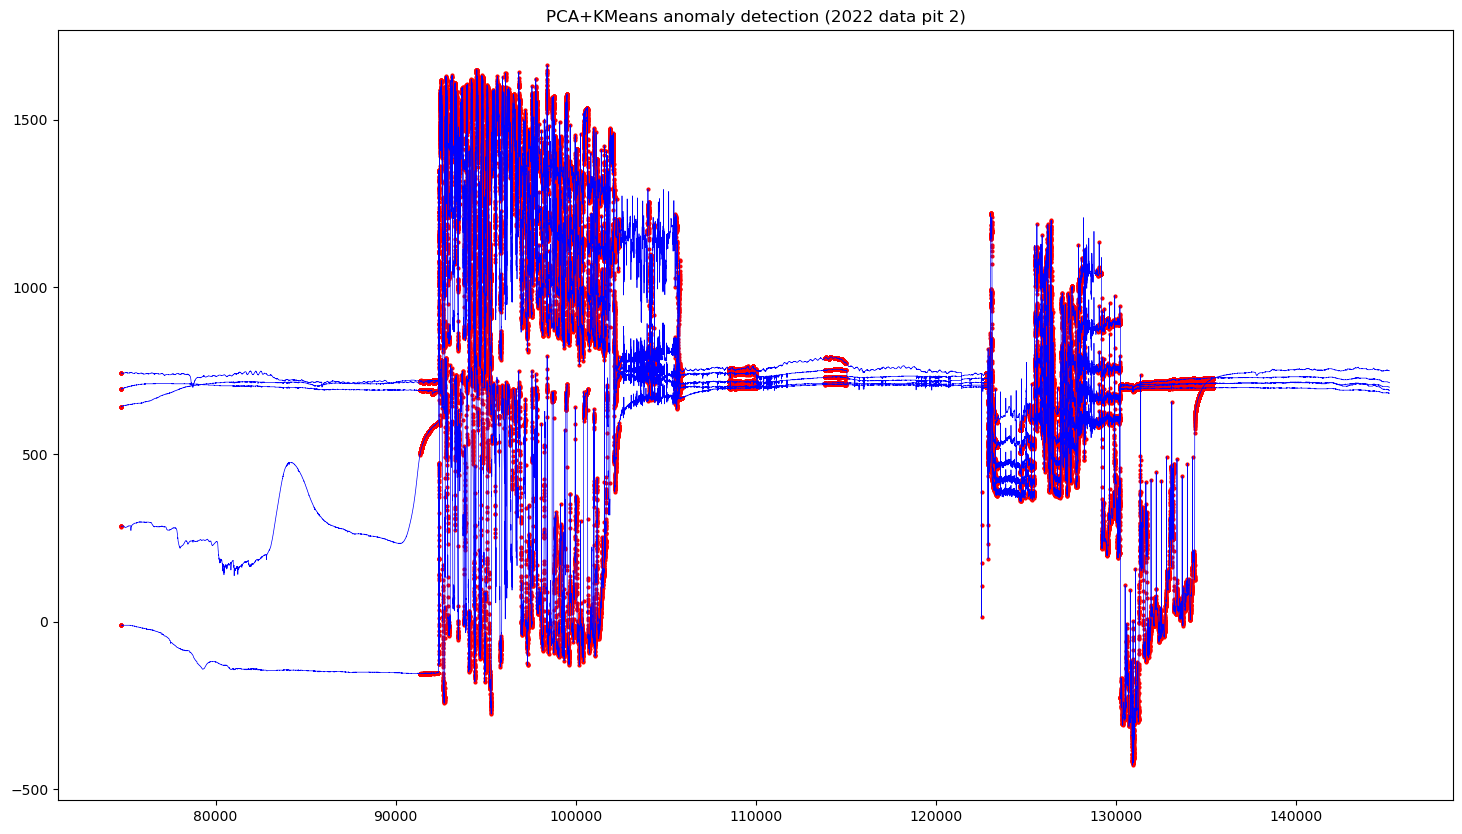

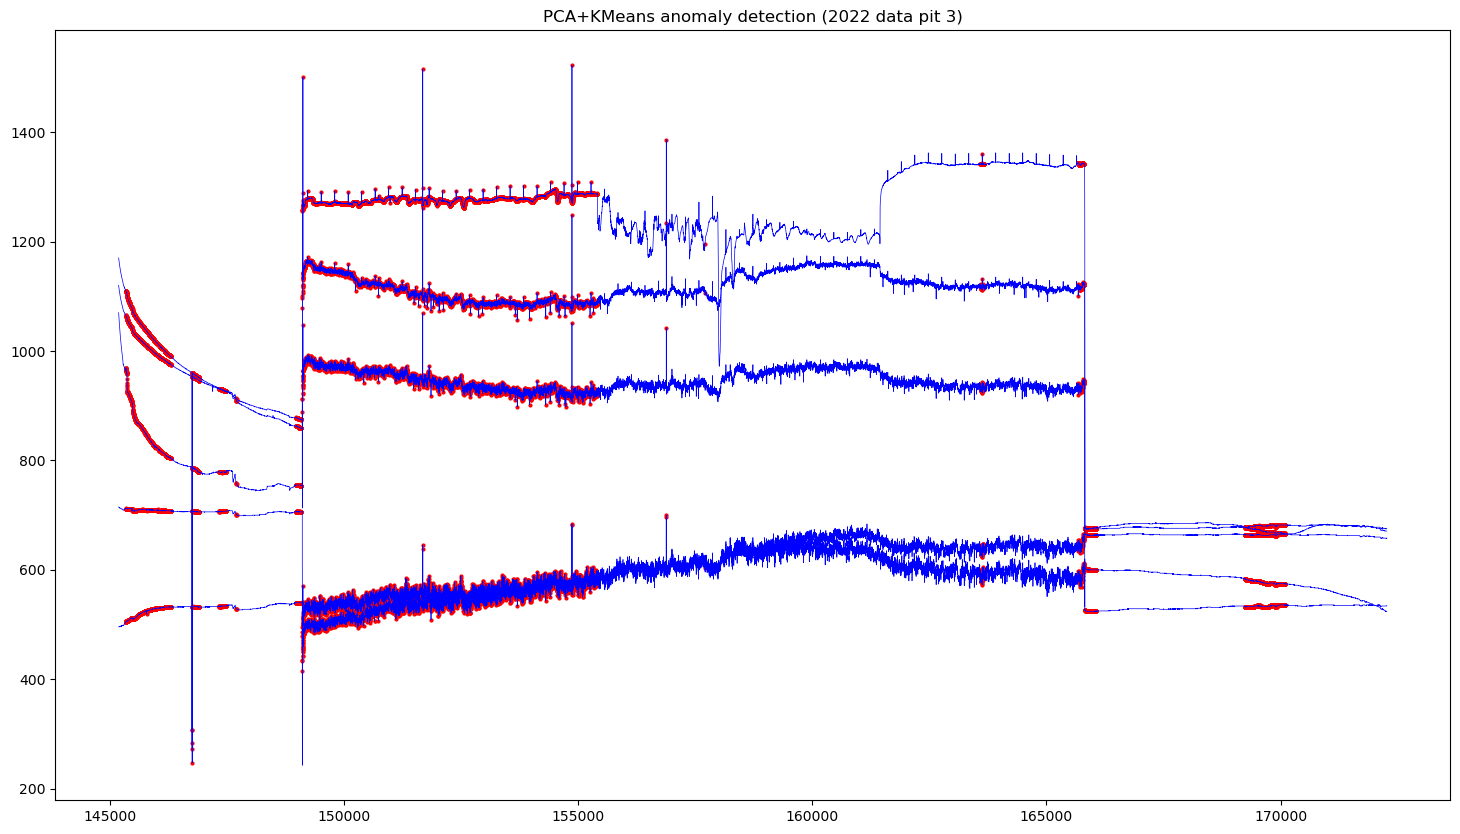

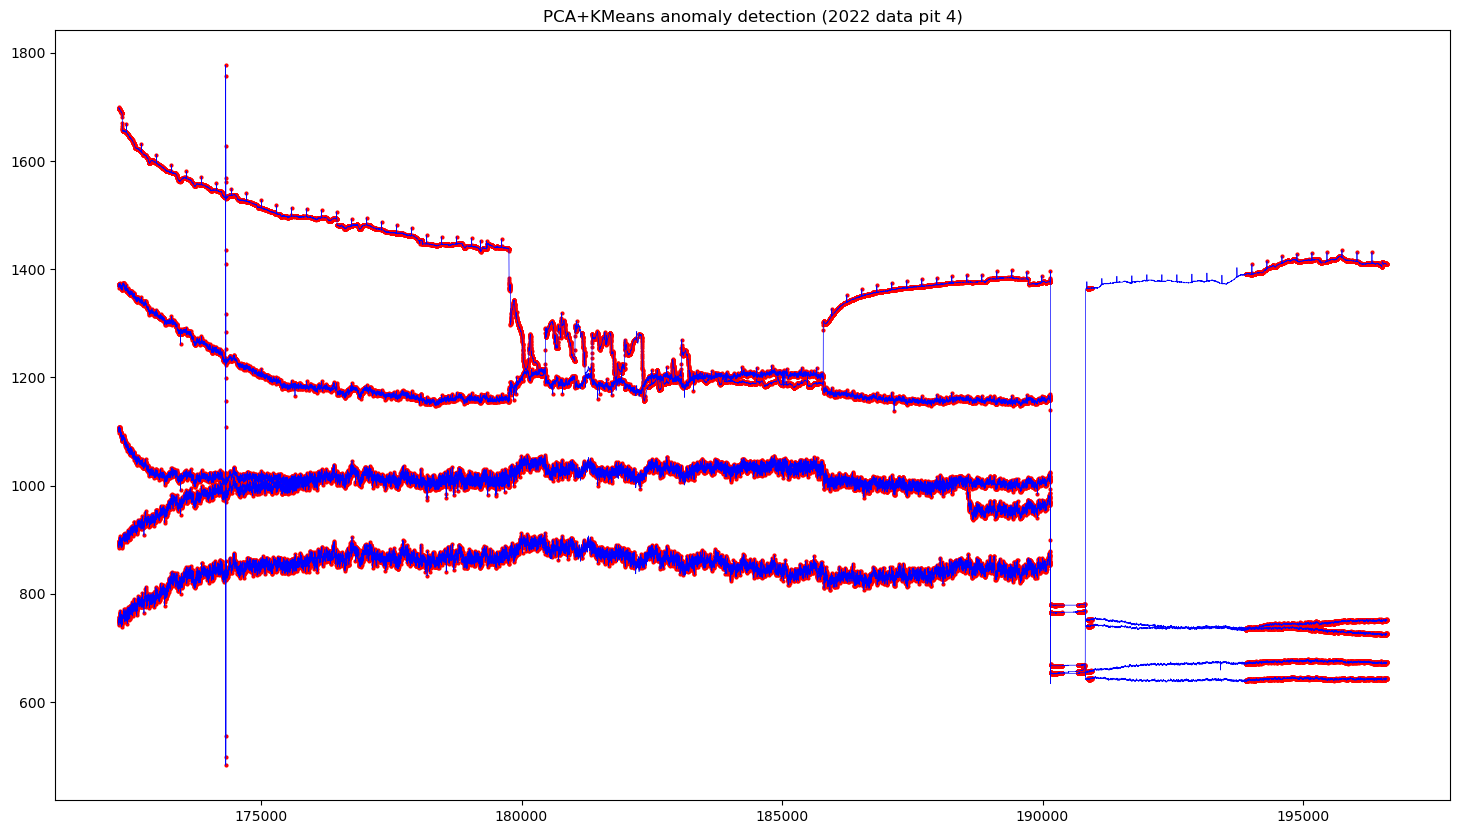

In [13]:
n_clusters = 5
pca_components = 5
outliers_fraction = 0.37
pca_data = filter_pca_data(training_data_2022)

anomaly_data = pca_kmeans(pca_data, training_data_2022, n_clusters, pca_components, outliers_fraction)
true_positives, true_negatives, false_positives, false_negatives = get_acc_metric_dfs(anomaly_data)
plt.figure(figsize=(18,10))
plt.plot(anomaly_data['d_from_cc'])
plt.figure(figsize=(18,10))
plt.plot(anomaly_data.index, anomaly_data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5)
plt.scatter(anomaly_data[anomaly_data['anomaly'] == True].index, np.repeat(-600, anomaly_data[anomaly_data['anomaly'] == True].shape[0]), label='Detected anomalys')
plt.scatter(true_positives.index, np.repeat(-700, true_positives.shape[0]), label='True positives')
plt.scatter(false_positives.index, np.repeat(-800, false_positives.shape[0]), label='False positives')
plt.scatter(false_negatives.index, np.repeat(-900, false_negatives.shape[0]), label='False negatives')
plt.title('PCA+KMeans anomaly detection (2022 data)')
plt.legend(loc=(0.86,0.2))

for p in range(1,5):
    data = anomaly_data[anomaly_data['pit_number'] == p]
    plt.figure(figsize=(18,10))
    plt.plot(data.index, data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5, c='blue')
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(1)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(2)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(3)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(4)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(5)'], c='red', s=4)
    plt.title(f'PCA+KMeans anomaly detection (2022 data pit {p})')

## Visualizing clusters

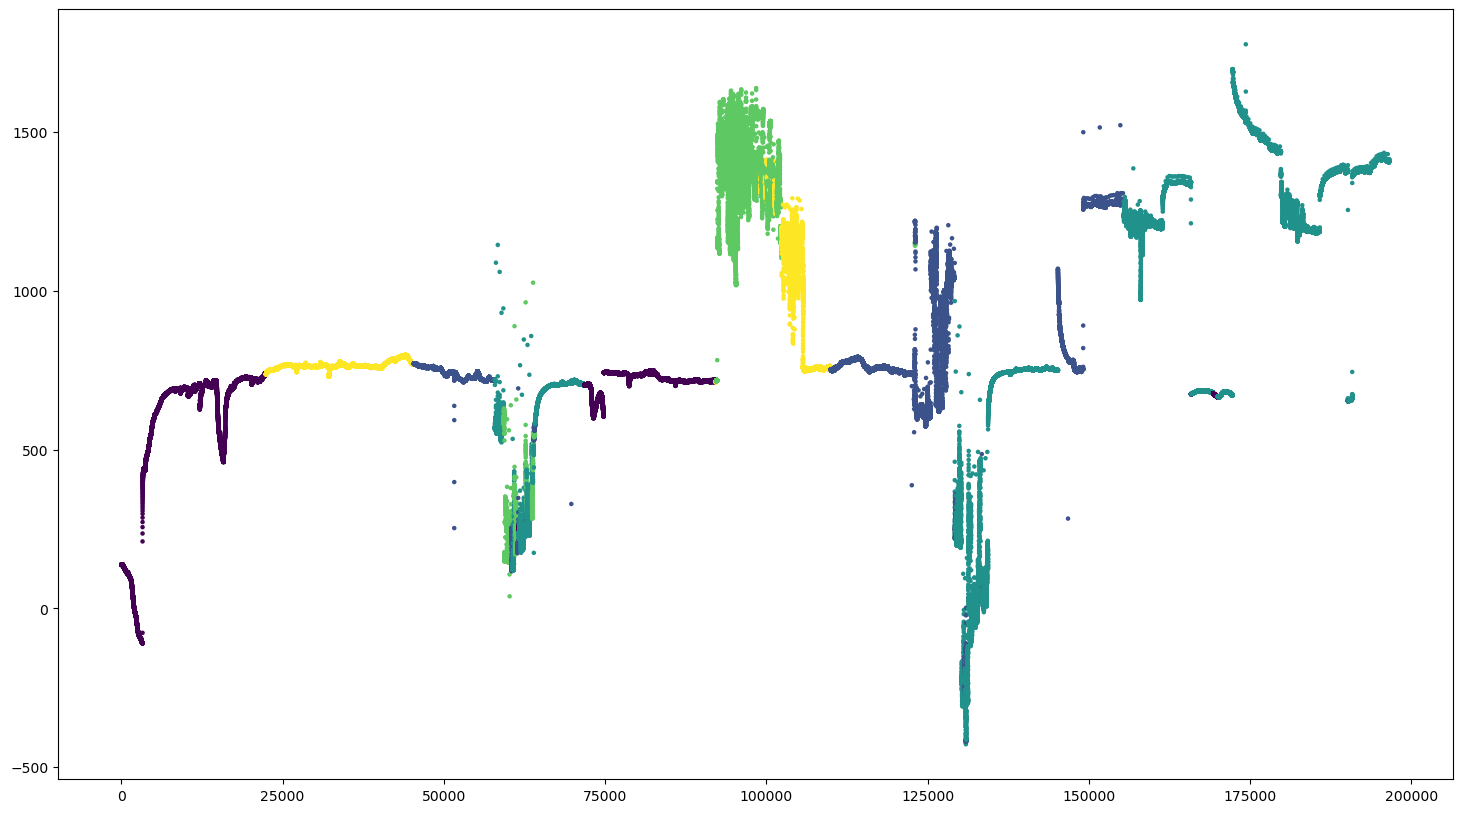

In [14]:
plt.figure(figsize=(18,10))
plt.scatter(anomaly_data.index, anomaly_data['Redox_Avg(1)'], s=5, c=anomaly_data['cluster'])

In [15]:
outliers_fraction = 0.10
data = training_data_2022[training_data_2022['pit_number'] == 4]
pca_data = filter_pca_data(data)

for components in range(5,8):
    for clusters in range(2,8):
        anomaly_data = pca_kmeans(pca_data, data, clusters, components, outliers_fraction)
        acc, prec, rec = get_acc_metrics(get_acc_metric_dfs(anomaly_data))
        print(f'Components: {components}, clusters: {clusters}, acc: {acc}, precision: {prec}, recall: {rec}')

Components: 5, clusters: 2, acc: 0.09407608249116753, precision: 0.8331963845521775, recall: 0.08566359719523528
Components: 5, clusters: 3, acc: 0.08824254375154054, precision: 0.8040262941659819, recall: 0.0826645264847512
Components: 5, clusters: 4, acc: 0.08512036808807821, precision: 0.7884141331142153, recall: 0.08105939004815409
Components: 5, clusters: 5, acc: 0.08659929340234984, precision: 0.7958093672966311, recall: 0.08181971783391062
Components: 5, clusters: 6, acc: 0.08528469312299729, precision: 0.7892358258011504, recall: 0.08114387091323814
Components: 5, clusters: 7, acc: 0.08528469312299729, precision: 0.7892358258011504, recall: 0.08114387091323814
Components: 6, clusters: 2, acc: 0.08142305480239914, precision: 0.7699260476581758, recall: 0.07915857058376277
Components: 6, clusters: 3, acc: 0.08166954235477775, precision: 0.7711585866885785, recall: 0.07928529188138886
Components: 6, clusters: 4, acc: 0.07254950291676937, precision: 0.7255546425636812, recall: 0.07

In [16]:
for pit in range(1,5):
    df = training_data_2022[training_data_2022['pit_number'] == pit]
    errors = df[((df['Redox_error_flag(1)'] == True) | (df['Redox_error_flag(2)'] == True) | (df['Redox_error_flag(3)'] == True) | (df['Redox_error_flag(4)'] == True) | (df['Redox_error_flag(5)'] == True))].shape[0]
    print(errors)
    print(errors / df.shape[0])

6038
0.08075647335758614
24732
0.3511870953084176


19581
0.723213296398892
23674
0.9725577191685153


## 2022 per pit

Pit: 1, components: 6, clusters: 7, acc: 0.880256259362294, precision: 0.4025279208185648, recall: 0.9968532626697582
Pit: 2, components: 6, clusters: 7, acc: 0.7926275133477224, precision: 0.8595569440499858, recall: 0.4894873038977842
Pit: 3, components: 6, clusters: 7, acc: 0.43460757156048013, precision: 0.8945521698984303, recall: 0.24738266687094632
Pit: 4, components: 6, clusters: 7, acc: 0.1771423876427574, precision: 0.8742810188989318, recall: 0.1797752808988764


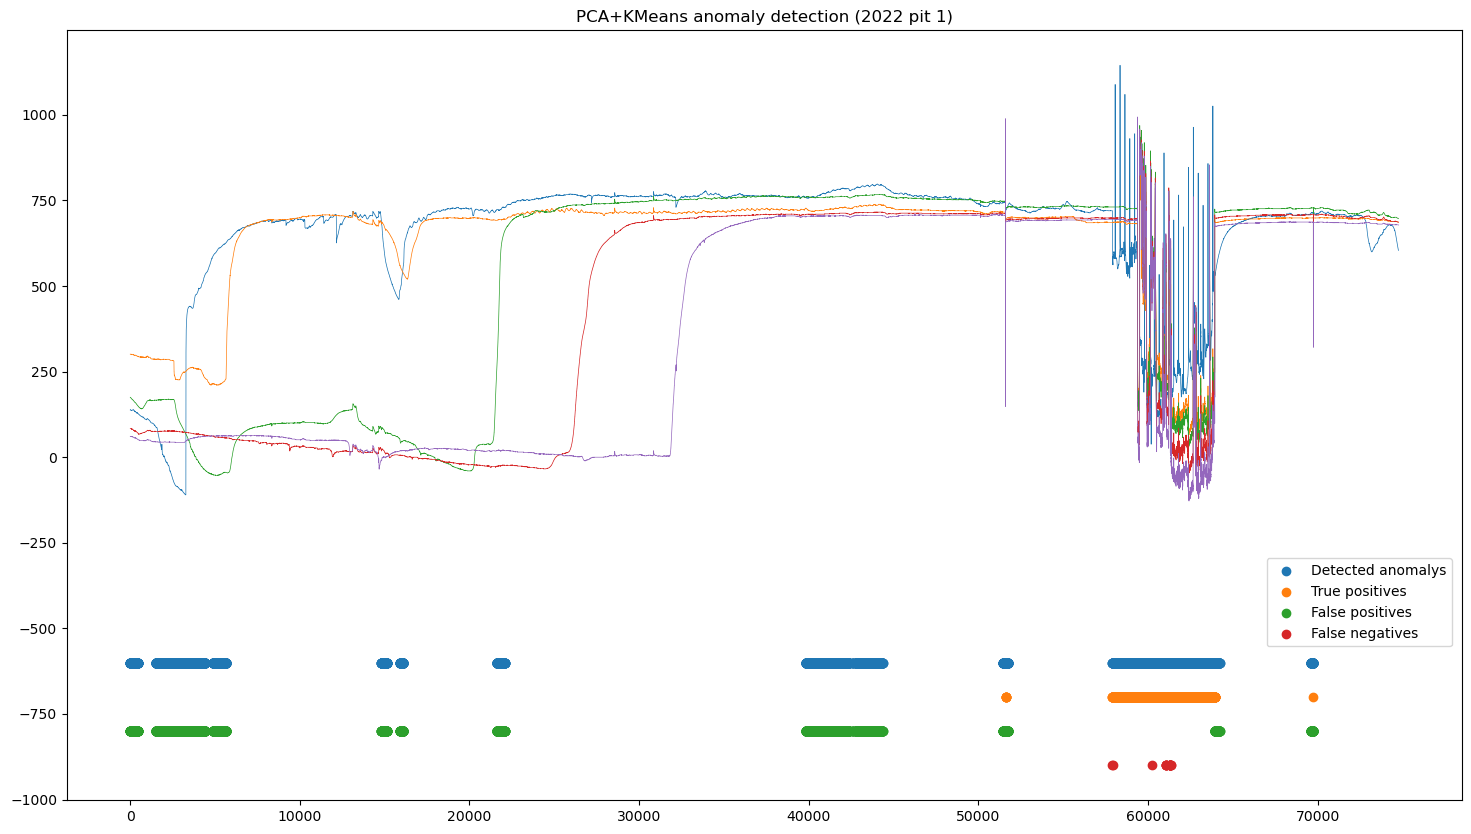

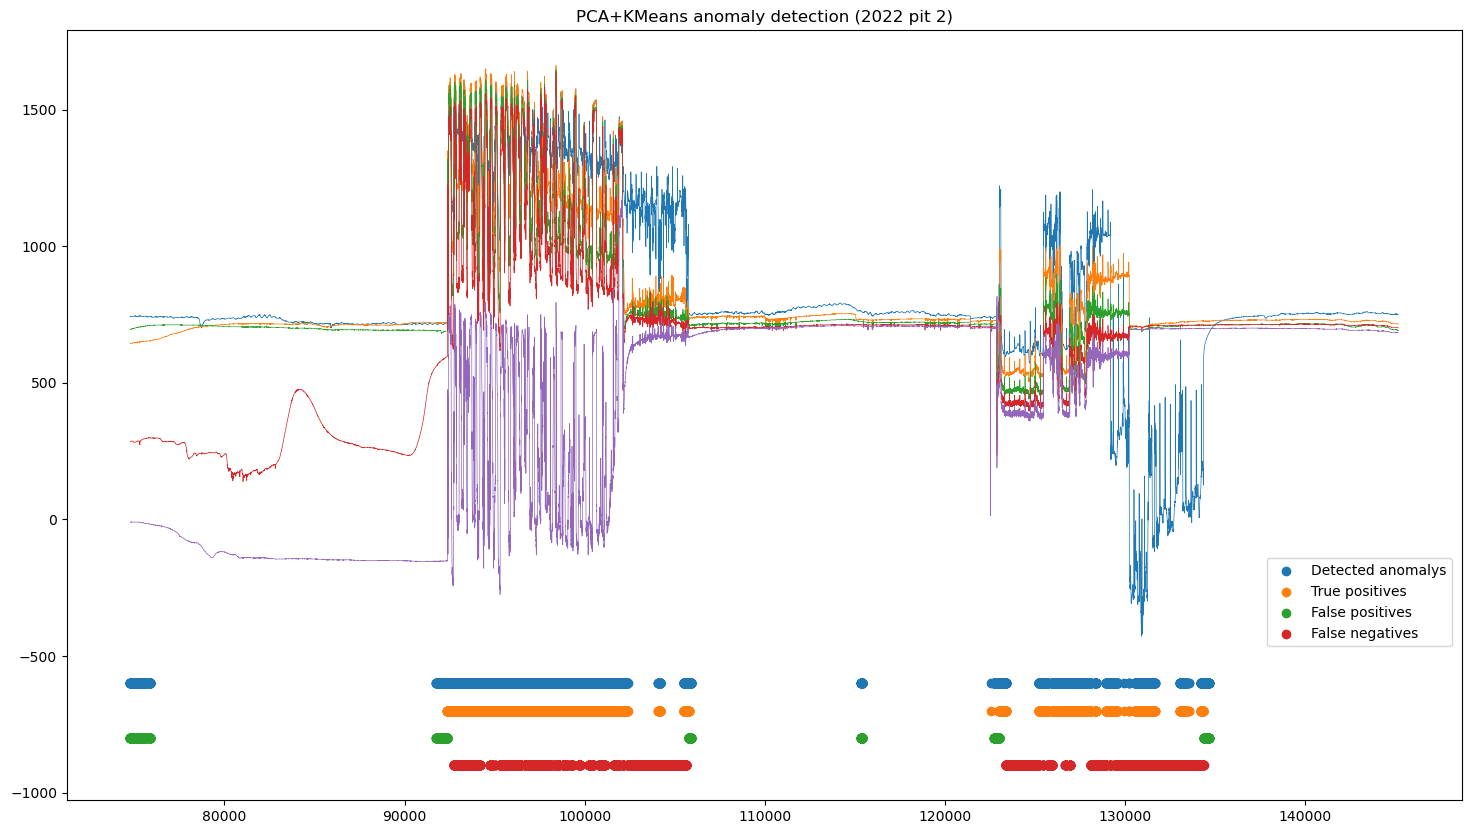

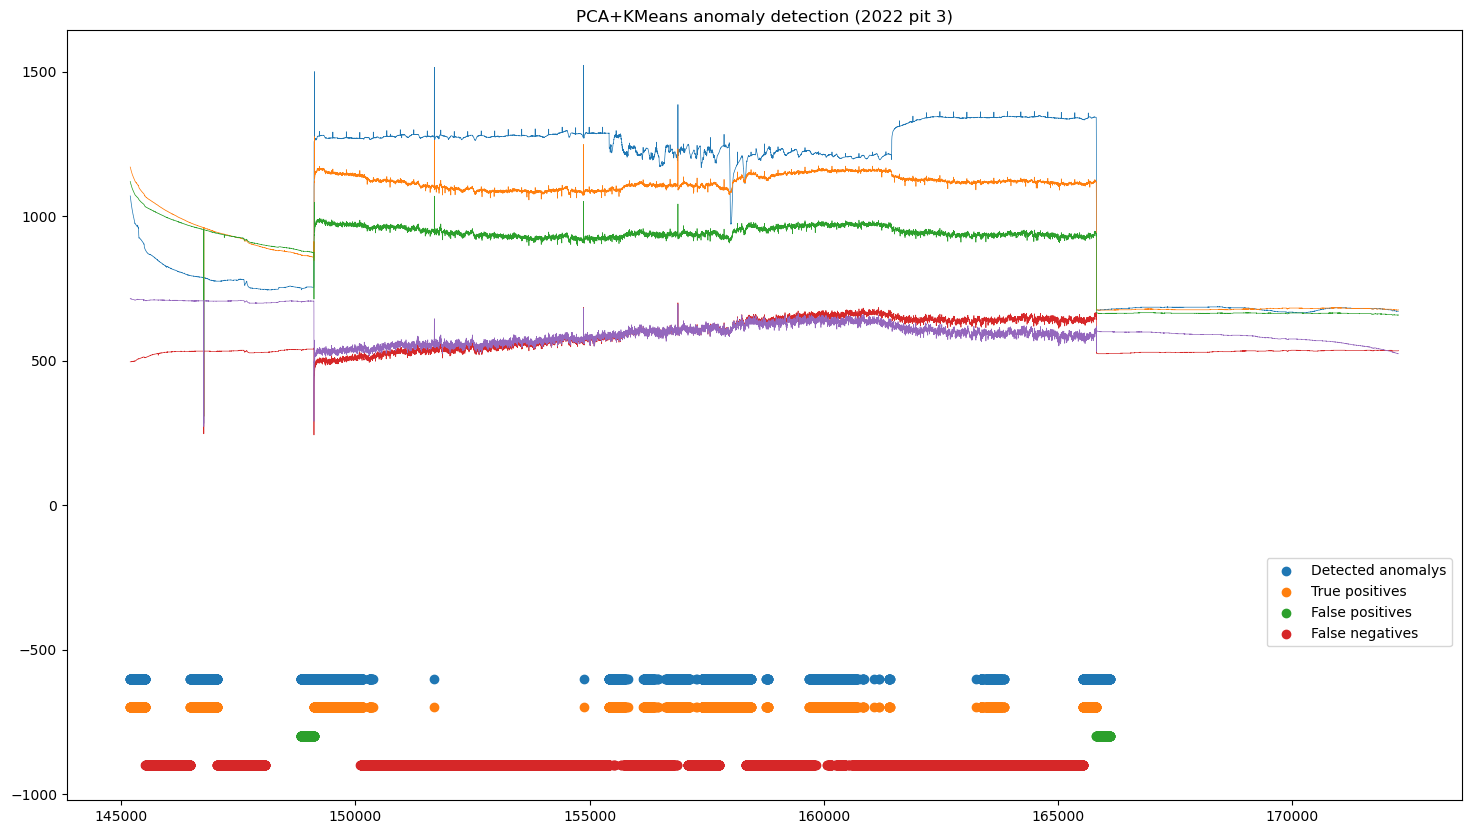

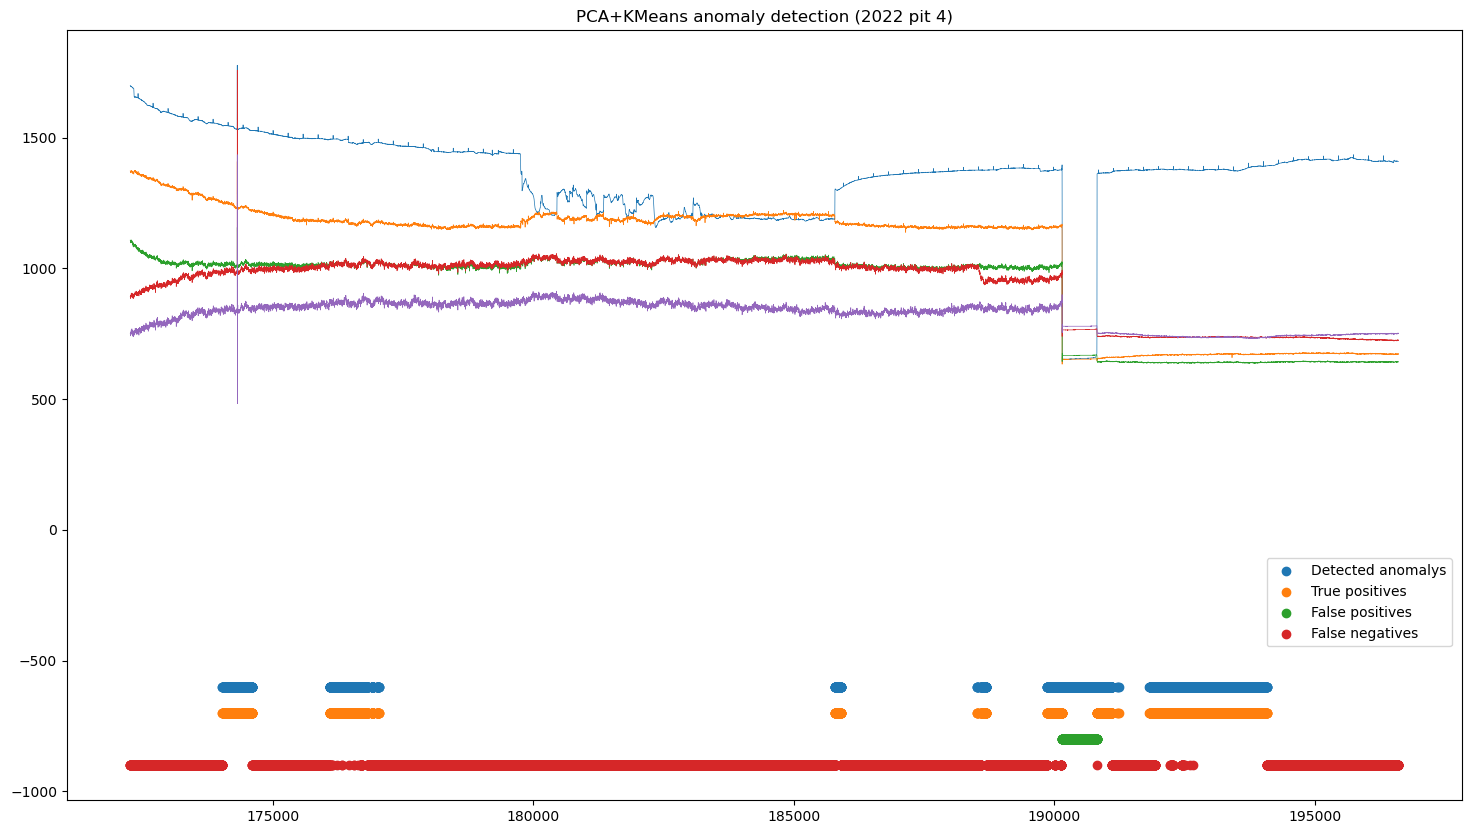

In [17]:
for pit in range(1,5):
    data = training_data_2022[training_data_2022['pit_number'] == pit]
    n_clusters = 7
    pca_components = 6
    outliers_fraction = 0.20
    pca_data = filter_pca_data(data)

    anomaly_data = pca_kmeans(pca_data, data, n_clusters, pca_components, outliers_fraction)
    true_positives, true_negatives, false_positives, false_negatives = get_acc_metric_dfs(anomaly_data)
    acc, prec, rec = get_acc_metrics((true_positives, true_negatives, false_positives, false_negatives))
    print(f'Pit: {pit}, components: {pca_components}, clusters: {n_clusters}, acc: {acc}, precision: {prec}, recall: {rec}')

    plt.figure(figsize=(18,10))
    plt.plot(anomaly_data.index, anomaly_data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5)
    plt.scatter(anomaly_data[anomaly_data['anomaly'] == True].index, np.repeat(-600, anomaly_data[anomaly_data['anomaly'] == True].shape[0]), label='Detected anomalys')
    plt.scatter(true_positives.index, np.repeat(-700, true_positives.shape[0]), label='True positives')
    plt.scatter(false_positives.index, np.repeat(-800, false_positives.shape[0]), label='False positives')
    plt.scatter(false_negatives.index, np.repeat(-900, false_negatives.shape[0]), label='False negatives')
    plt.legend(loc=(0.86,0.2))
    plt.title(f'PCA+KMeans anomaly detection (2022 pit {pit})')

## 2022 depth specific

(0.6963312971430606, 0.798677517802645, 0.2197682230433322)
(0.7421481213983083, 0.7463377416073245, 0.2430028816534729)
(0.7452252948745989, 0.7663275686673449, 0.24876574806399948)
(0.8413704357379367, 0.7474059003051882, 0.359126014273145)
(0.9246779140324197, 0.7145473041709054, 0.604345020434502)


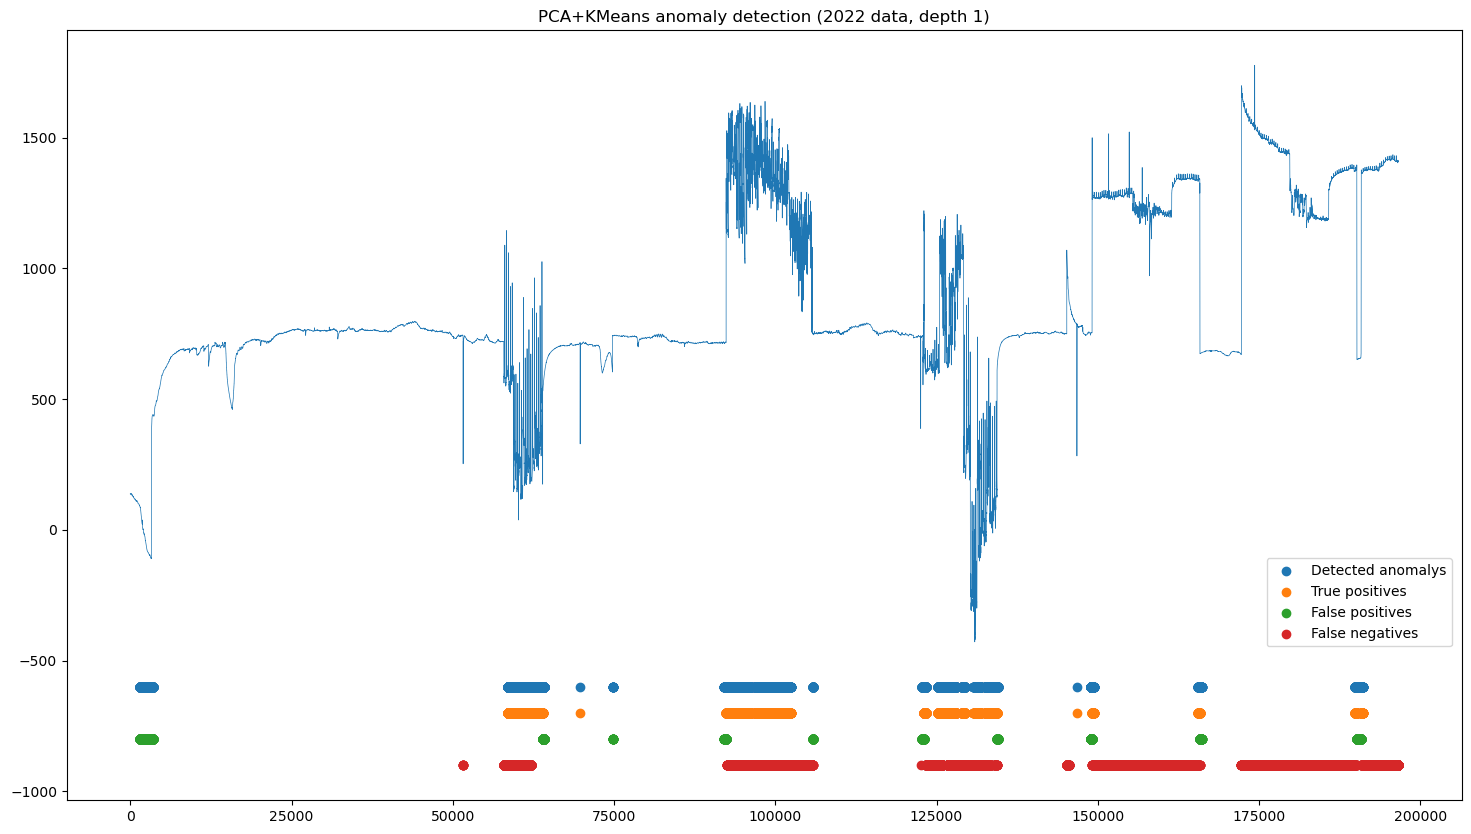

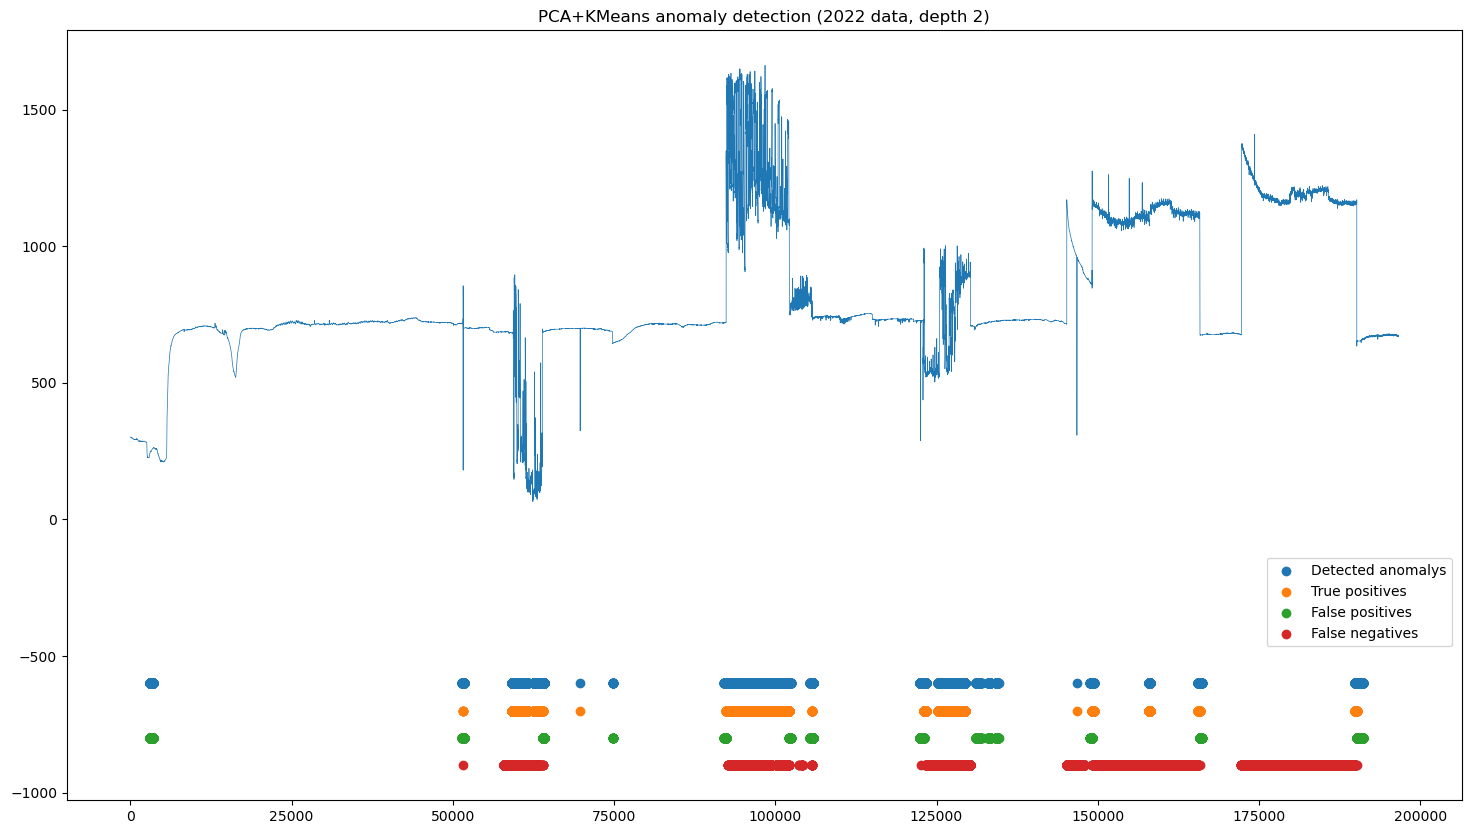

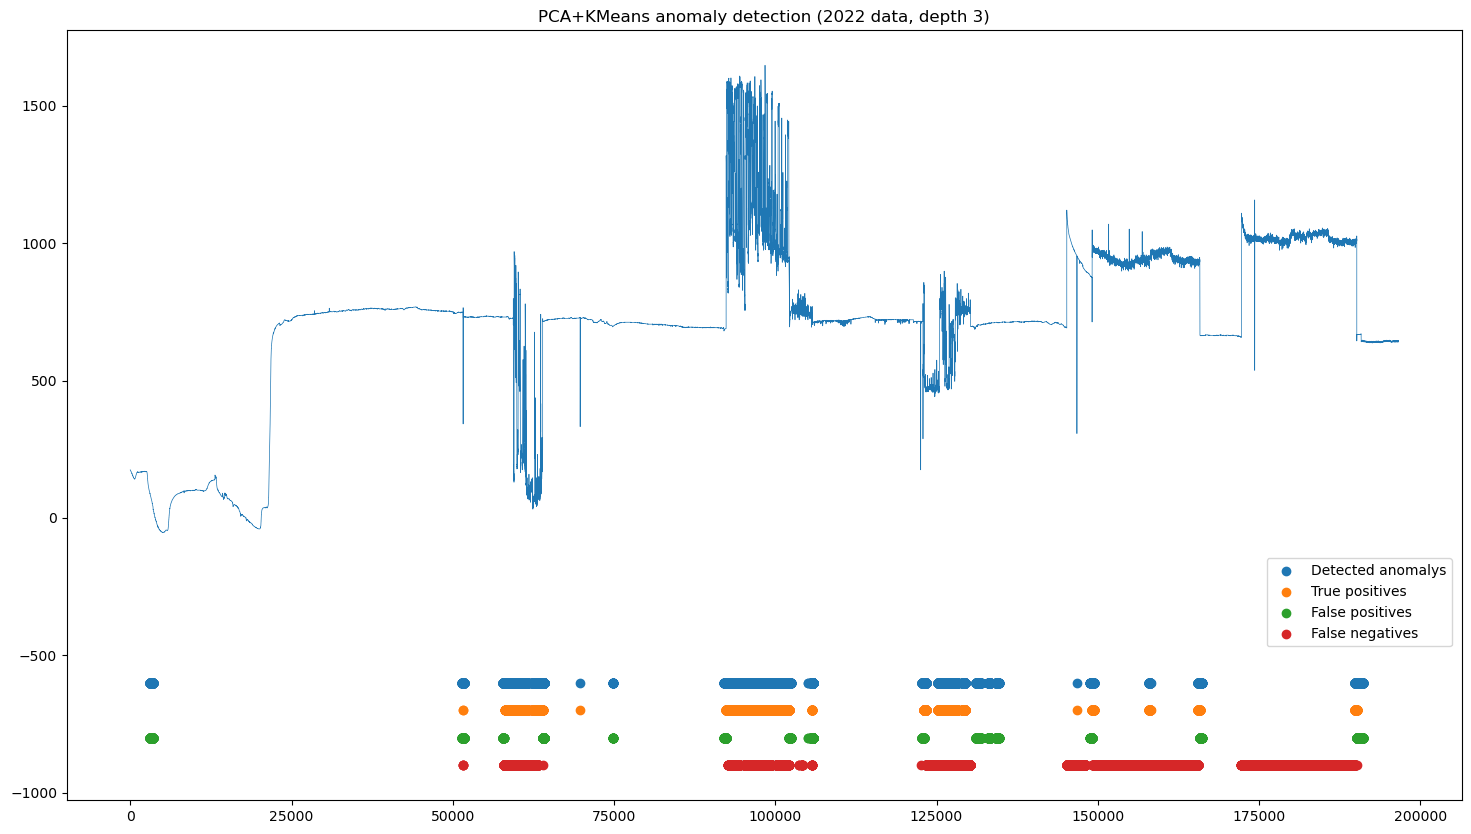

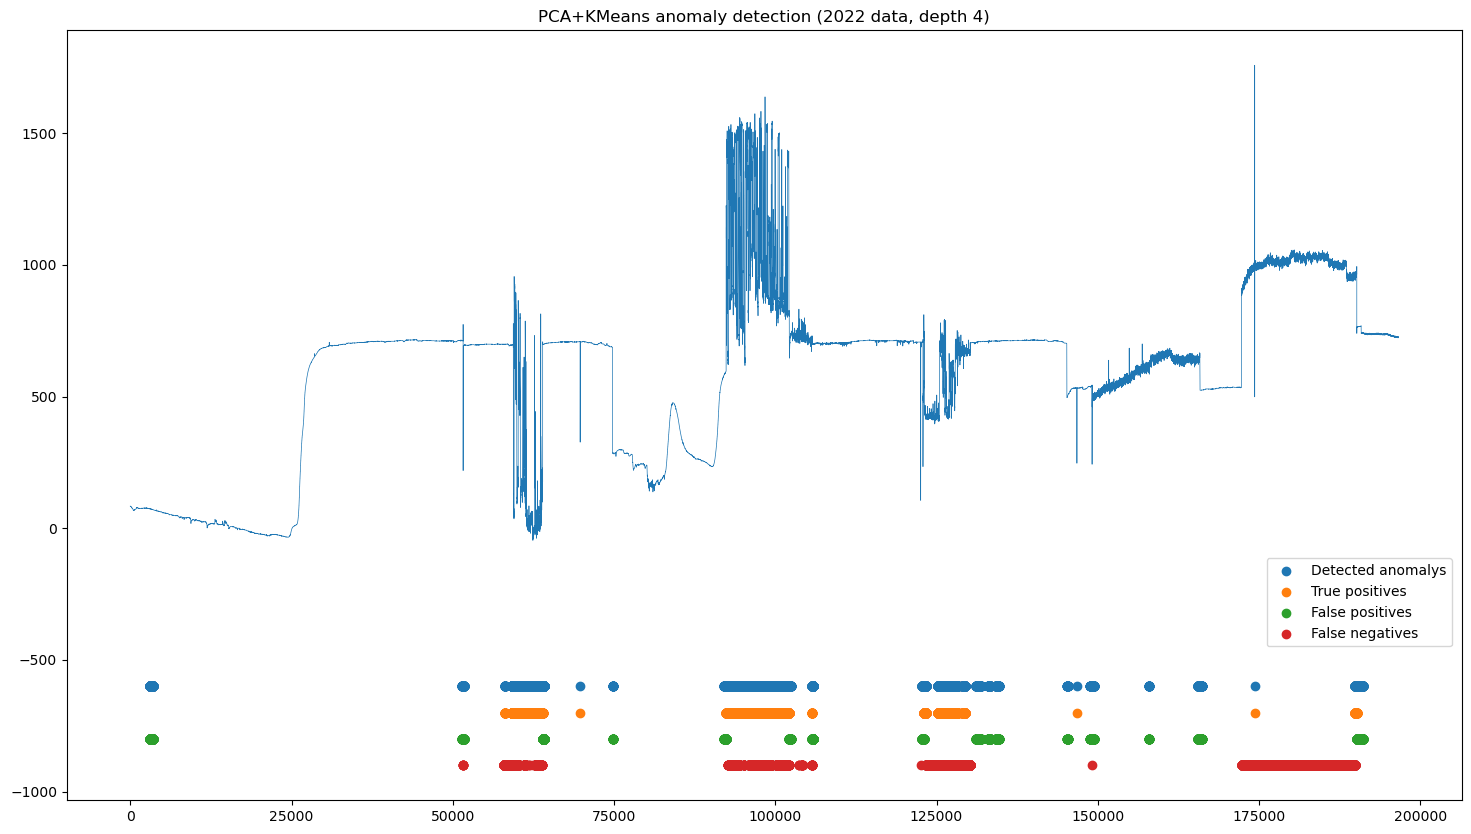

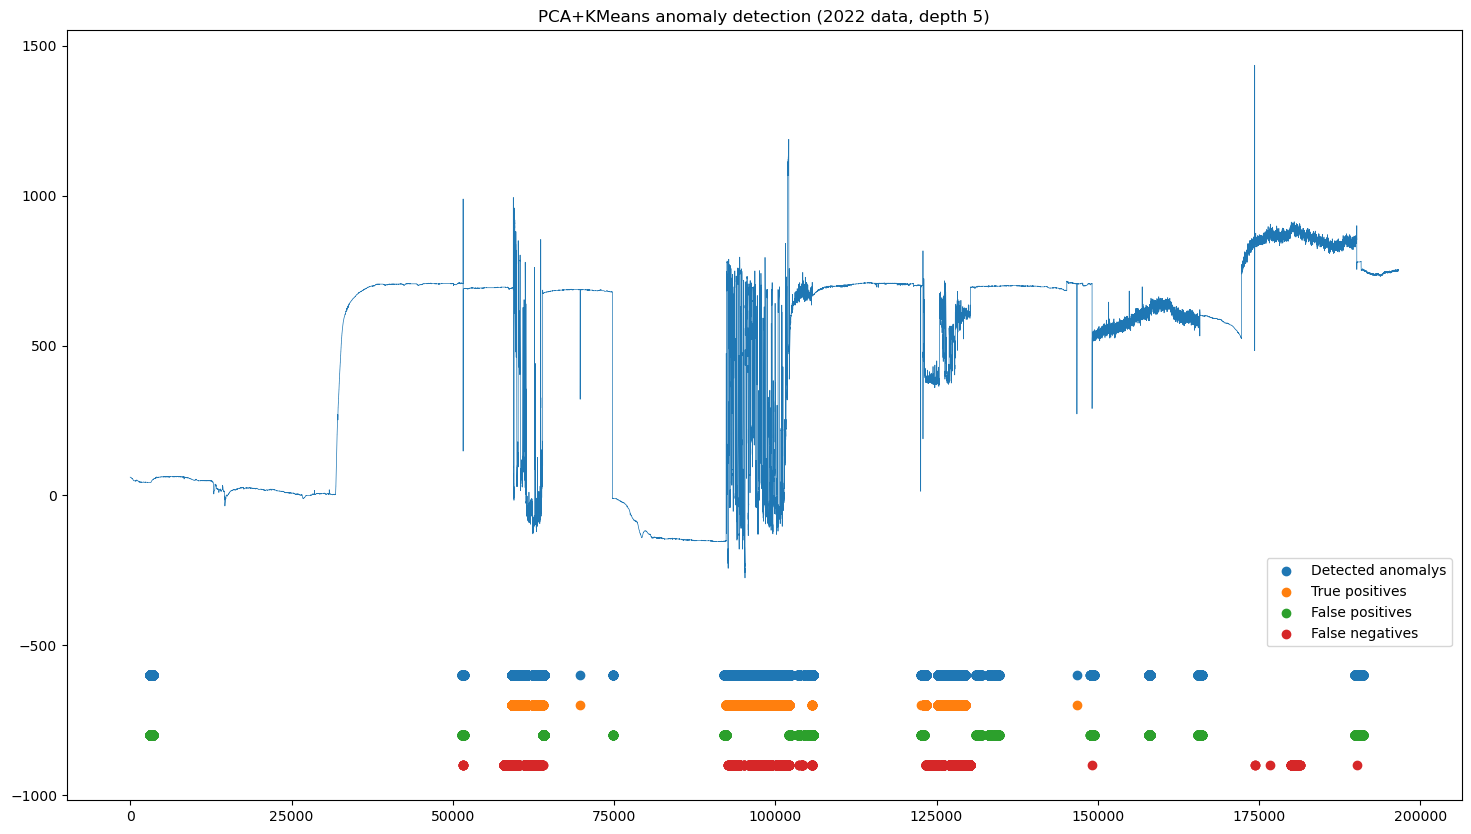

In [18]:
n_clusters = 5
pca_components = 5
outliers_fraction = 0.10

for d in range(1,6):
    depths = [1,2,3,4,5]
    depths.remove(d)
    pca_data = filter_pca_data(training_data_2022, depths)

    anomaly_data = pca_kmeans(pca_data, training_data_2022, n_clusters, pca_components, outliers_fraction)
    true_positives, true_negatives, false_positives, false_negatives = get_ind_depth_acc_metric_dfs(anomaly_data, d)
    print(get_acc_metrics((true_positives, true_negatives, false_positives, false_negatives)))

    plt.figure(figsize=(18,10))
    plt.plot(anomaly_data.index, anomaly_data[[f'Redox_Avg({d})']], linewidth=0.5)
    plt.scatter(anomaly_data[anomaly_data['anomaly'] == True].index, np.repeat(-600, anomaly_data[anomaly_data['anomaly'] == True].shape[0]), label='Detected anomalys')
    plt.scatter(true_positives.index, np.repeat(-700, true_positives.shape[0]), label='True positives')
    plt.scatter(false_positives.index, np.repeat(-800, false_positives.shape[0]), label='False positives')
    plt.scatter(false_negatives.index, np.repeat(-900, false_negatives.shape[0]), label='False negatives')
    plt.title(f'PCA+KMeans anomaly detection (2022 data, depth {d})')
    plt.legend(loc=(0.86,0.2))

## 2022 per pit and depth

In [19]:
n_clusters = 5
outliers_fraction = 0.10
pca_components = 6
for pit in range(1,5):
   data = training_data_2022[training_data_2022['pit_number'] == pit]
   pca_data = filter_pca_data(data)
   for d in range(1,6):
      depths = [1,2,3,4,5]
      depths.remove(d)
      pca_data = filter_pca_data(data, depths)

      anomaly_data = pca_kmeans(pca_data, data, n_clusters, pca_components, outliers_fraction)
      true_positives, true_negatives, false_positives, false_negatives = get_ind_depth_acc_metric_dfs(anomaly_data, d)
      acc, prec, rec = get_acc_metrics((true_positives, true_negatives, false_positives, false_negatives))
      print(f'Pit: {pit}, depth: {d}, acc: {acc}, precision: {prec}, recall: {rec}')

Pit: 1, depth: 1, acc: 0.9783329766745131, precision: 0.7954788657035848, recall: 0.984928784365684
Pit: 1, depth: 2, acc: 0.9763535202225551, precision: 0.7855805243445693, recall: 0.9726730705531633
Pit: 1, depth: 3, acc: 0.9776374919751766, precision: 0.7920010700909578, recall: 0.9806227227558795
Pit: 1, depth: 4, acc: 0.9796169484271346, precision: 0.8018994114499732, recall: 0.9928784365684001
Pit: 1, depth: 5, acc: 0.9786004707896426, precision: 0.7968164794007491, recall: 0.9865849619079166
Pit: 2, depth: 1, acc: 0.7317391798250596, precision: 0.9146549275773928, recall: 0.2604318292091218
Pit: 2, depth: 2, acc: 0.7931671021242758, precision: 0.6783584209031525, recall: 0.2797165944489987
Pit: 2, depth: 3, acc: 0.7941610814495058, precision: 0.6823345640443056, recall: 0.281586966713549
Pit: 2, depth: 4, acc: 0.8269056003635125, precision: 0.8460664583925022, recall: 0.3491561181434599
Pit: 2, depth: 5, acc: 0.8233840736112689, precision: 0.8284578244816814, recall: 0.341889357

## 2023

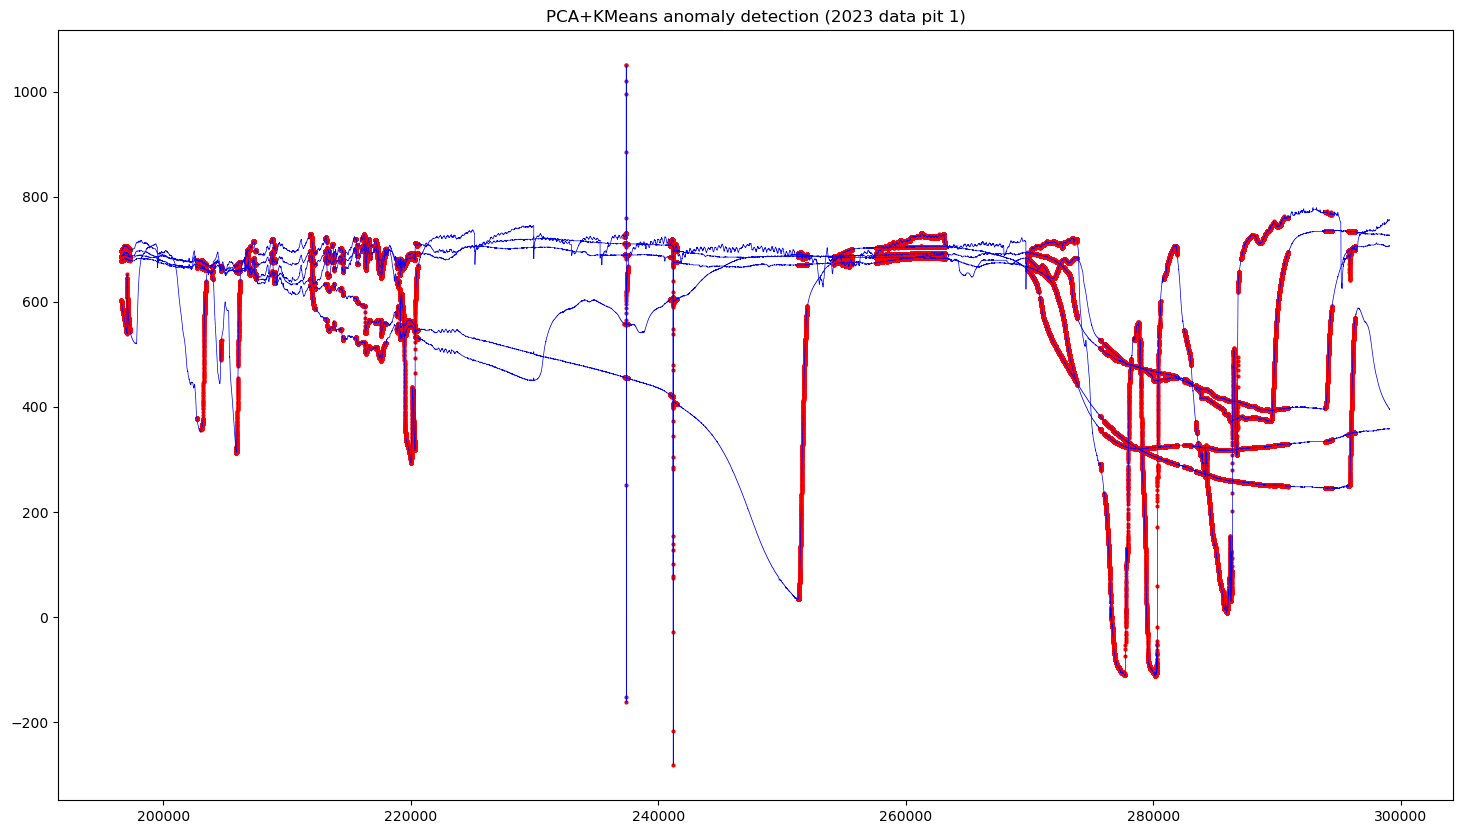

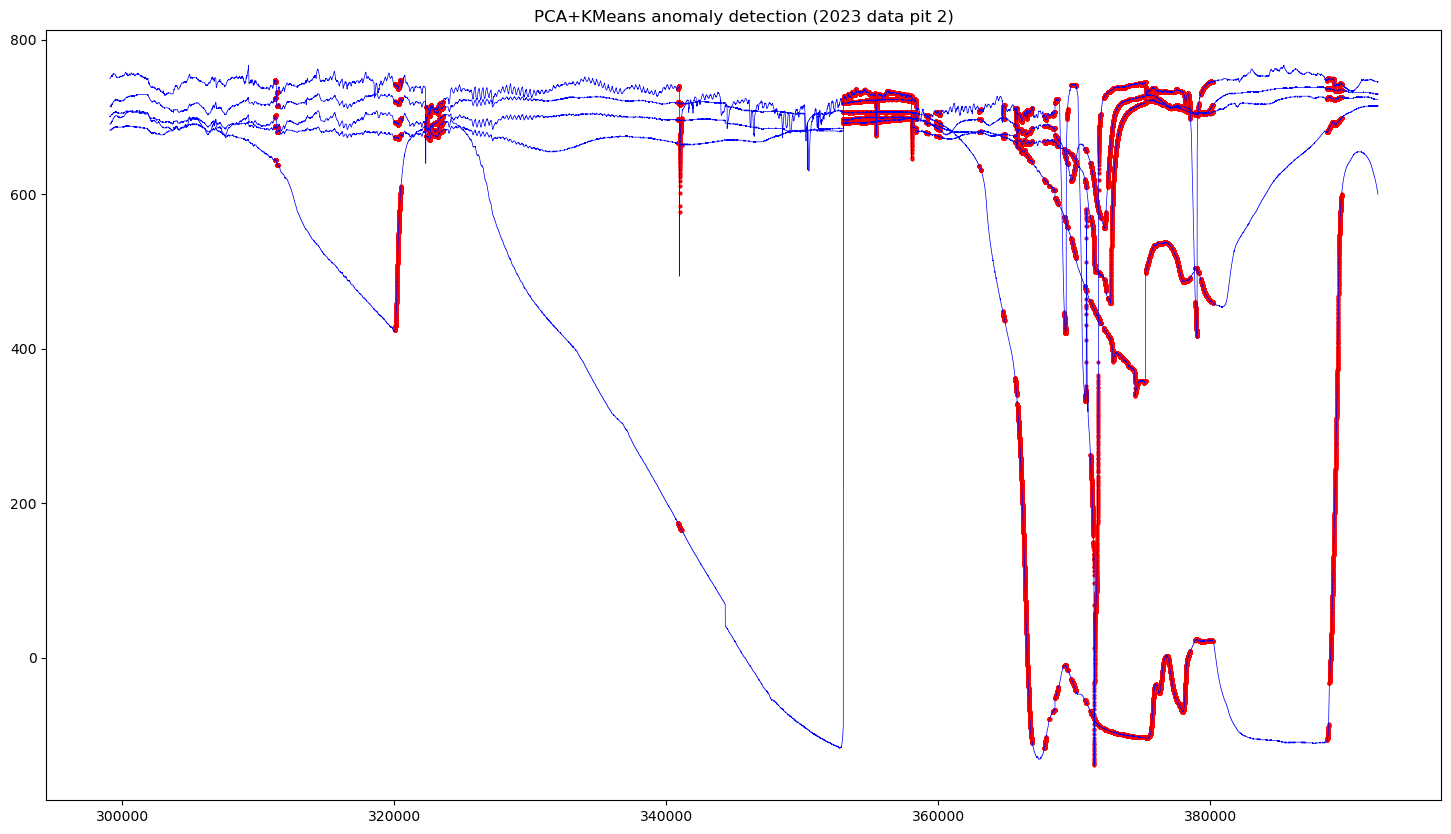

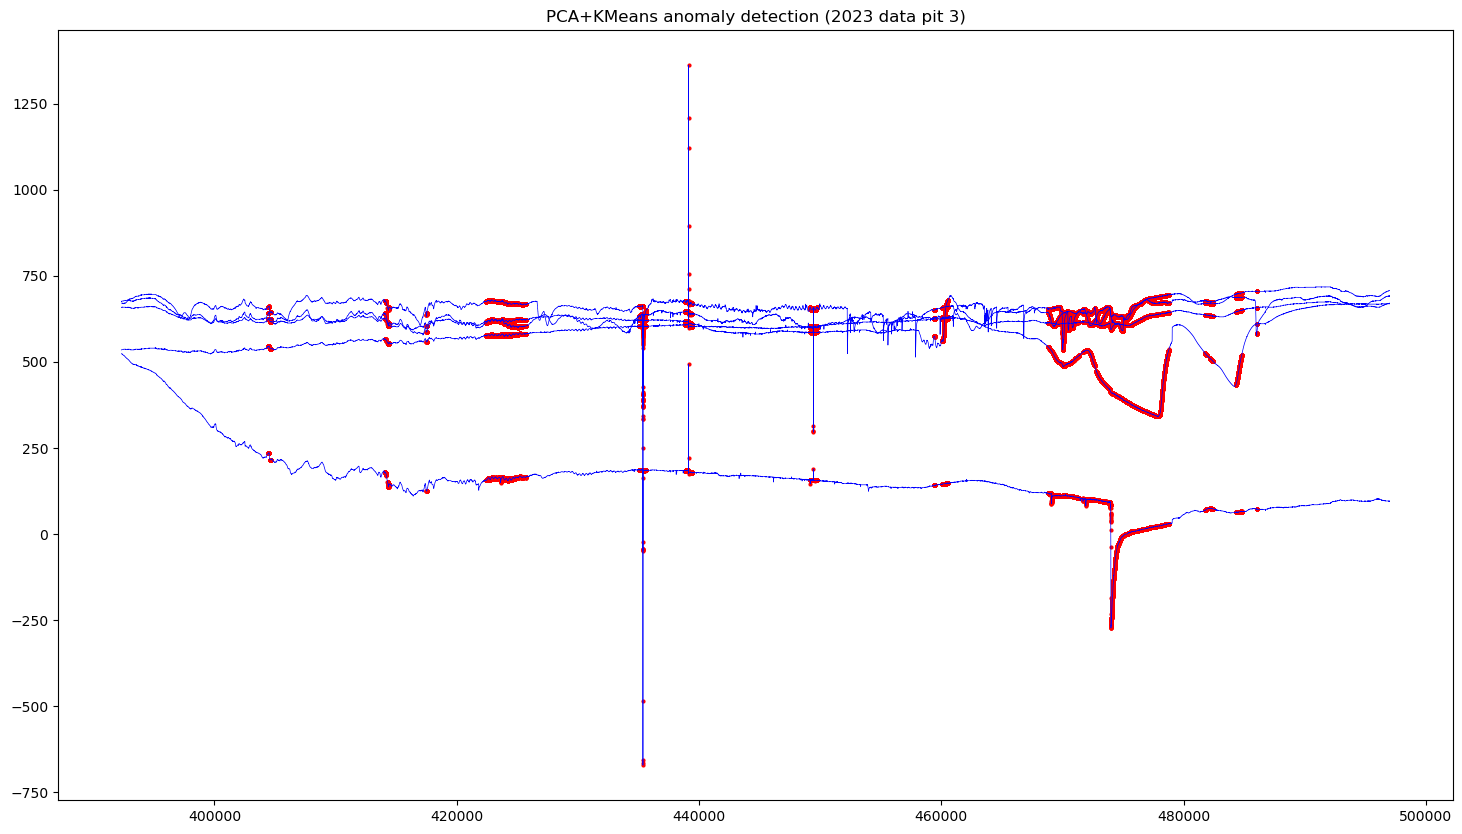

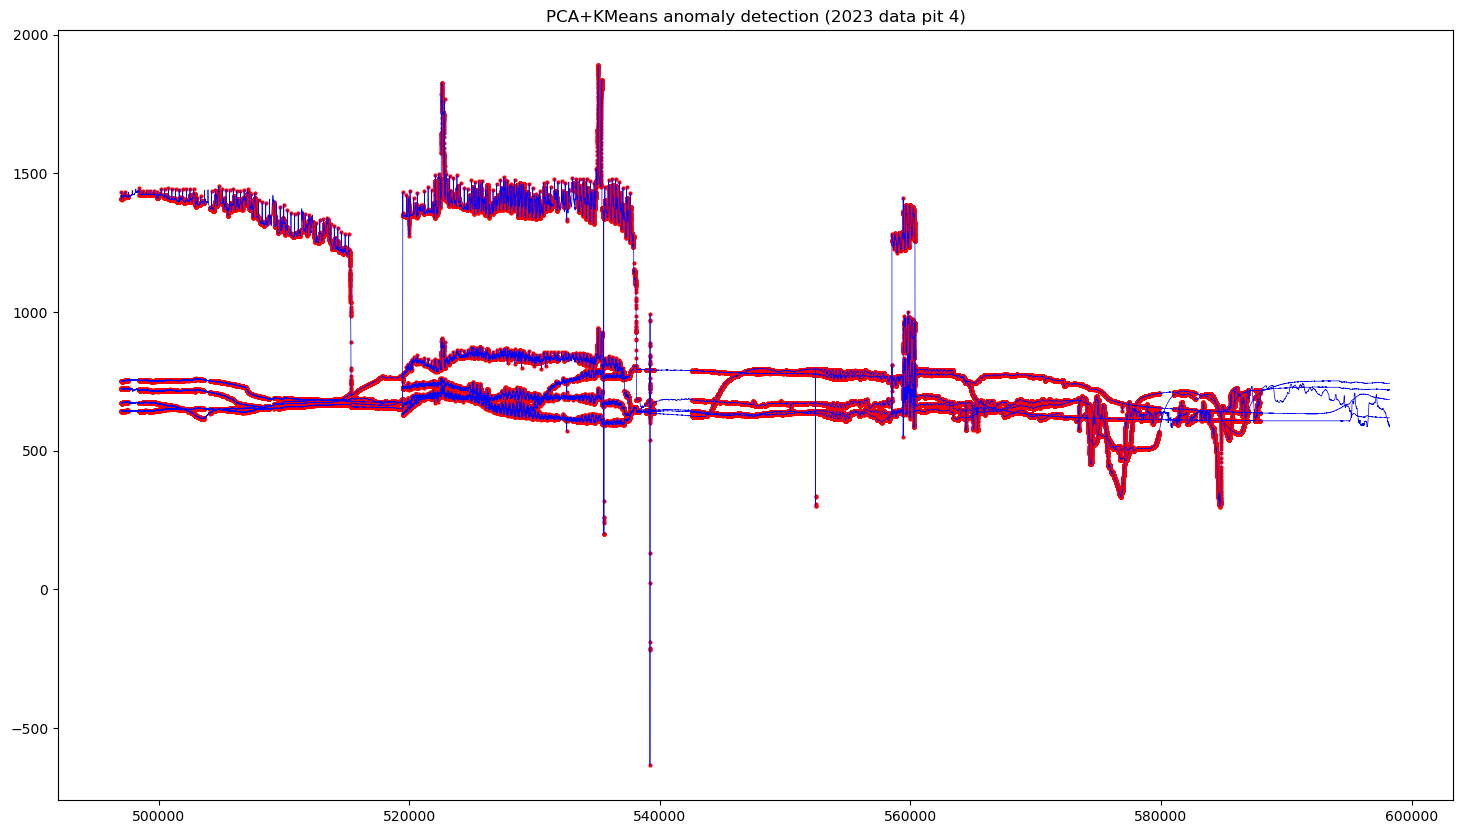

In [20]:
n_clusters = 5
pca_components = 5
outliers_fraction = 0.37
pca_data = filter_pca_data(training_data_2023)

anomaly_data = pca_kmeans(pca_data, training_data_2023, n_clusters, pca_components, outliers_fraction)
true_positives, true_negatives, false_positives, false_negatives = get_acc_metric_dfs(anomaly_data)

for p in range(1,5):
    data = anomaly_data[anomaly_data['pit_number'] == p]
    plt.figure(figsize=(18,10))
    plt.plot(data.index, data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5, c='blue')
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(1)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(2)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(3)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(4)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(5)'], c='red', s=4)
    plt.title(f'PCA+KMeans anomaly detection (2023 data pit {p})')